# Run Ad-Hoc Data Bias Analysis

## Run Bias Analysis In The Notebook using `smclarify`
https://github.com/aws/amazon-sagemaker-clarify


In [3]:
!pip install -q smclarify>=0.1

In [4]:
from smclarify.bias import report
from typing import Dict
from collections import defaultdict
import pandas as pd
import seaborn as sns

# Read Dataset From S3

In [5]:
%store -r bias_data_s3_uri

In [6]:
print(bias_data_s3_uri)

s3://sagemaker-us-east-1-211125778552/bias-detection-1709010764/amazon_reviews_us_giftcards_software_videogames.csv


In [7]:
%store -r balanced_bias_data_s3_uri

In [8]:
print(balanced_bias_data_s3_uri)

s3://sagemaker-us-east-1-211125778552/bias-detection-1709010764/amazon_reviews_us_giftcards_software_videogames_balanced.csv


In [9]:
!aws s3 cp $bias_data_s3_uri ./data-clarify/

download: s3://sagemaker-us-east-1-211125778552/bias-detection-1709010764/amazon_reviews_us_giftcards_software_videogames.csv to data-clarify/amazon_reviews_us_giftcards_software_videogames.csv


In [10]:
!aws s3 cp $balanced_bias_data_s3_uri ./data-clarify/

download: s3://sagemaker-us-east-1-211125778552/bias-detection-1709010764/amazon_reviews_us_giftcards_software_videogames_balanced.csv to data-clarify/amazon_reviews_us_giftcards_software_videogames_balanced.csv


# Analyze Unbalanced Data

In [11]:
df = pd.read_csv("./data-clarify/amazon_reviews_us_giftcards_software_videogames.csv")
df.shape

(1000, 15)

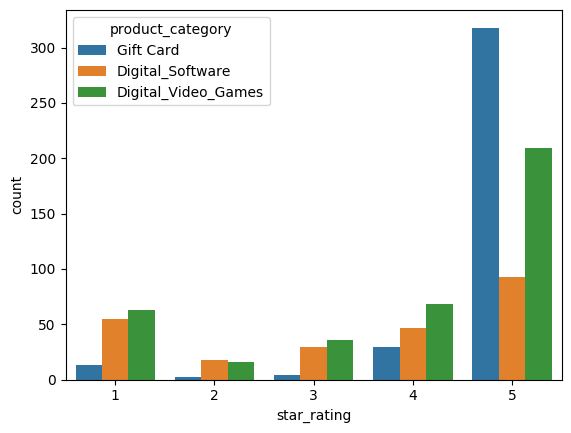

In [12]:
sns.countplot(data=df, x="star_rating", hue="product_category")

# Calculate Bias Metrics on Unbalanced Data

## Define 
* Facet Column (= Product Category), 
* Label Column (= Star Rating), 
* Positive Label Value (= 5,4)

In [14]:
report.LabelColumn?

Init signature:
report.LabelColumn(
    name: str,
    series: pandas.core.series.Series,
    positive_label_values: Union[Any, NoneType] = None,
)
Docstring:      <no docstring>
Init docstring:
initialize the label column with name, data  and positive values
:param data: data series for the label column
:param positive_label_values: positive label values for target column
File:           ~/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/smclarify/bias/report.py
Type:           type
Subclasses:     


In [15]:
facet_column = report.FacetColumn(name="product_category")

label_column = report.LabelColumn(
    name="star_rating", 
    series=df["star_rating"], 
    positive_label_values=[5, 4]
)

## Run SageMaker Clarify Bias Report

In [16]:
report.bias_report(
    df=df, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

[{'value_or_threshold': 'Gift Card',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.268},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': -0.2903587250693834},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': 0.07302487542160971},
   {'name': 'KL',
    'description': 'Kullback-Liebler Divergence (KL)',
    'value': 0.40503704219982173},
   {'name': 'KS',
    'description': 'Kolmogorov-Smirnov Distance (KS)',
    'value': 0.2903587250693834},
   {'name': 'LP', 'description': 'L-p Norm (LP)', 'value': 0.4106292469464828},
   {'name': 'TVD',
    'description': 'Total Variation Distance (TVD)',
    'value': 0.2903587250693834}]},
 {'value_or_threshold': 'Digital_Software',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.516},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    '

# Balance the data

In [17]:
df_grouped_by = df.groupby(["product_category", "star_rating"])[["product_category", "star_rating"]]
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))
df_balanced.shape

(30, 2)

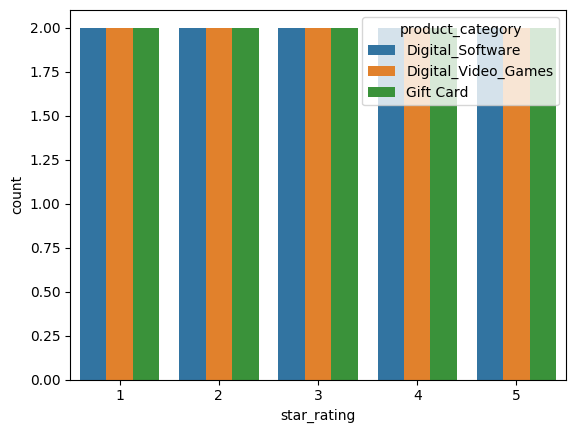

In [18]:
import seaborn as sns

sns.countplot(data=df_balanced, x="star_rating", hue="product_category")

# Calculate Bias Metrics on Balanced Data

## Define 
* Facet Column (= Product Category), 
* Label Column (= Star Rating), 
* Positive Label Value (= 5,4)

In [20]:
from smclarify.bias import report

facet_column = report.FacetColumn(name="product_category")

label_column = report.LabelColumn(
    name="star_rating", 
    series=df_balanced["star_rating"], 
    positive_label_values=[5, 4]
)

## Run SageMaker Clarify Bias Report

In [21]:
report.bias_report(
    df=df_balanced, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

[{'value_or_threshold': 'Digital_Software',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.3333333333333333},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': 0.0},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': 0.0},
   {'name': 'KL',
    'description': 'Kullback-Liebler Divergence (KL)',
    'value': 0.0},
   {'name': 'KS',
    'description': 'Kolmogorov-Smirnov Distance (KS)',
    'value': 0.0},
   {'name': 'LP', 'description': 'L-p Norm (LP)', 'value': 0.0},
   {'name': 'TVD',
    'description': 'Total Variation Distance (TVD)',
    'value': 0.0}]},
 {'value_or_threshold': 'Digital_Video_Games',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.3333333333333333},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': 0.0},
   {'name': 'JS',
    'description': 'Jense

In [22]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [23]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>